In [3]:
import numpy as np
from copy import deepcopy
from scipy.stats import multivariate_normal, invgamma, invwishart, norm, bernoulli, multinomial
import pdb
import math
import matplotlib.pyplot as plt

# define hyper-parameters
P = 104
K = 2
R = 50
n1 = 150
n2 = 50
n = n1 + n2
nk = [n1, n2]

# generate data
mu01 = [0.8] * 4
mu02 = [-0.8] * 4
B1 = np.ones((2, 4)) * 0.8
B2 = np.ones((2, 4)) * 0.8
Sigma1 = np.ones((4, 4)) * 0.5
Sigma1 += np.diag(np.ones(4) * 0.5)
Sigma2 = deepcopy(Sigma1)
noise = multivariate_normal(np.zeros(100), np.ones((100, 100)) * 0.1 + np.diag(np.ones(100) * 0.9))

# bayesian reference
a0 = a_tilde = 3
ak = [3] * K
b0 = b_tilde = 0.1
bk = [0.1] * K
b0k = [0] * K
dk = [P + 3] * K
Q = 0.1 * np.diag(np.ones(P))
m_0k = [0] * K
h = 4
h1 = 1
e = -3
f = 0
wrk = np.array([np.ones(50) * 0.05] * K)


class MCMC_sampler:
    def __init__(self, X, Z, g):
        self.X = X  # N * P
        self.Z = Z  # N * R
        self.g = g  # N * 1
        self.gamma = bernoulli(0.05).rvs(P)  # P * 1
        self.delta = []
        for k in range(2):
            self.delta.append(np.apply_along_axis(lambda x: bernoulli(x).rvs(R), 0, wrk[k, :]))
        self.delta = np.array(self.delta)  # R * K
        self.m_0k = m_0k
        self.test_gamma = np.array([1] * 4 + [0] * 100)
        self.test_delta = np.array([[1] * 2 + [0] * 48 for _ in range(2)])

        '''============记录MCMC采样数据============'''
        self.total_gamma = np.zeros(P)
        self.total_delta = np.zeros((K, R))
        self.total_mu0 = []

    def init(self):
        self.sigma2 = np.apply_along_axis(
            lambda ab: invgamma(ab[0], scale=1 / ab[1]).rvs(P),
            0, [[a0] + ak, [b0] + bk]
        ).squeeze()  # P * (K+1)

        self.beta = []
        self.Gamma_0 = []
        self.nu = []
        self.mu_0 = []
        for k in range(2):
            sigma2_k = self.sigma2[:, k + 1]  # P

            self.beta.append(np.apply_along_axis(lambda sigma: norm(b0k[k], sigma).rvs(R), 0, [h * sigma2_k]))
            Gamma_0k = invwishart(dk[k], Q).rvs(1)  # P * P
            self.Gamma_0.append(Gamma_0k)

            m_0k = np.ones(P) * self.m_0k[k]
            nu_k = multivariate_normal(m_0k, h1 * Gamma_0k).rvs(1).squeeze()  # P
            self.nu.append(nu_k)
            self.mu_0.append(multivariate_normal(nu_k, h1 * Gamma_0k).rvs(1))  # P

        self.beta = np.array(self.beta)  # K * R * P
        self.Gamma_0 = np.array(self.Gamma_0)  # K * P * P
        self.nu = np.array(self.nu)  # K * P
        self.mu_0 = np.array(self.mu_0)  # K * P
        self.det_Q = np.linalg.det(Q)
        self.b_0_p = []
        for j in range(P):
            self.b_0_p.append(b0 + sum(X[:, j] ** 2 / 2))
        self.b_0_p = np.array(self.b_0_p)

    def one_epoch(self, epoch):
        gamma_N = self.random_walk_gamma()
        self.M_H_gamma(gamma_N)
        
        delta_N = self.random_walk_delta()
        self.M_H_delta(delta_N)
        
        mu_N = self.random_walk_mu_0()
        self.M_H_mu_0(mu_N)
        
        '''========1000 burned in======'''
        if epoch>=1000:
            self.total_gamma += self.gamma
            self.total_delta += self.delta
            self.total_mu0.append(self.mu_0)

    def random_walk_gamma(self):
        gamma_N = deepcopy(self.gamma)

        if np.random.uniform() < 0.5 or (gamma_N == 0).all():
            index = np.random.choice(np.arange(P))
            gamma_N[index] = 0 if gamma_N[index] == 1 else 1

        else:
            index1 = np.random.choice(np.where(self.gamma == 1)[0])
            index2 = np.random.choice(np.where(self.gamma == 0)[0])
            gamma_N[index1] = 0 if gamma_N[index1] == 1 else 1
            gamma_N[index2] = 0 if gamma_N[index2] == 1 else 1

        return gamma_N

    def random_walk_delta(self):
        delta_N = deepcopy(self.delta)
        for k in range(2):
            if np.random.uniform() < 0.5 or (delta_N[k, :] == 0).all():
                index = np.random.choice(np.arange(R))
                delta_N[k, index] = 0 if delta_N[k, index] == 1 else 1

            else:
                index1 = np.random.choice(np.where(self.delta[k, :] == 1)[0])
                index2 = np.random.choice(np.where(self.delta[k, :] == 0)[0])
                delta_N[k, index1] = 0 if delta_N[k, index1] == 1 else 1
                delta_N[k, index2] = 0 if delta_N[k, index2] == 1 else 1

        return delta_N

    def random_walk_mu_0(self):
        errors = norm(0, 0.1).rvs(K * P).reshape(2, -1)
        return self.mu_0 + errors

    def M_H_gamma(self, gamma_N):
        ratio = self.p_gamma(gamma_N) - self.p_gamma(self.gamma)
        if ratio >= 0:
            self.gamma = gamma_N
        elif np.log(np.random.uniform()) > ratio:
            return
        else:
            self.gamma = gamma_N

    def M_H_delta(self, delta_N):
        for k in range(2):
            ratio = self.p_delta(delta_N, k) - self.p_delta(self.delta, k)
            if ratio >= 0:
                # print(delta_N)
                self.delta[k, :] = delta_N[k, :]
            elif np.log(np.random.uniform()) > ratio:
                continue
            else:
                self.delta[k, :] = delta_N[k, :]

    def M_H_mu_0(self, mu_0_N):
        for k in range(2):
            ratio = self.p_mu_0(mu_0_N, k) - self.p_mu_0(self.mu_0, k)
            indexes = np.where(np.log(np.random.uniform(ratio)) < ratio)[0]
            self.mu_0[k, indexes] = mu_0_N[k, indexes]

    def p_x_j_gamma(self, gamma, k, delta, mu_0):
        Z_k_deltak = np.mat(Z[self.g == k, :][:, delta[k, :] == 1])
        abs_delta_k = sum(delta[k, :])

        matrix2 = np.matmul(Z_k_deltak.T, Z_k_deltak) + np.identity(abs_delta_k) / h
        matrix2 = np.linalg.inv(matrix2)
        matrix3 = np.identity(nk[k]) - np.matmul(np.matmul(Z_k_deltak, matrix2), Z_k_deltak.T)

        features = np.where(gamma == 1)[0]
        value = []
        for j in features:
            matrix1 = X[self.g == k, j] - mu_0[k, j]
            bk_p = np.matmul(np.matmul(matrix1.T, matrix3), matrix1) / 2 + bk[k]
            ak_p = ak[k] + nk[k] / 2

            value.append(np.log(np.linalg.det(matrix2)) / 2 - ak_p * np.log(bk_p) - nk[k] / 2 * np.log(2 * np.pi) +
                         np.log(math.gamma(ak_p)) - np.log(math.gamma(ak[k])) +
                         ak[k] * np.log(bk[k]) - abs_delta_k / 2 * np.log(h))

        return np.array(value).squeeze()

    def p_x_gamma_c(self, gamma):
        a0_p = a0 + n / 2
        value = -a0_p * np.log(self.b_0_p[gamma == 0]) + a0 * np.log(b0) - n / 2 * np.log(2 * np.pi) + \
                np.log(math.gamma(a0_p) / math.gamma(a0))
        return np.sum(value)

    def p_mu_0_gamma(self, gamma, mu_0):
        p_gamma = sum(gamma)
        value = 0
        for i in range(2):
            value += dk[i] / 2 * np.log(self.det_Q)
            det_Q_mu = Q + 2 * h1 * np.matmul(mu_0[i, :] - m_0k[i], (mu_0[i, :] - m_0k[i]).T)
            value -= (dk[i] + 1) / 2 * np.log(np.linalg.det(det_Q_mu))
            value += np.log(math.gamma((dk[i] + 1) / 2) / math.gamma((dk[i] - p_gamma + 1) / 2))
            value -= p_gamma / 2 * np.log(np.pi * 2 * h1)
        return value

    def p_mu_0_gamma_c(self, gamma):
        value = ((math.gamma(a_tilde + 0.5) - math.gamma(a_tilde)) - np.log(np.pi * 2) / 2 +
                 a_tilde * np.log(b_tilde)) * np.sum(gamma == 0) * 2
        for k in range(2):
            value -= np.sum(
                (a_tilde + 0.5) * np.log(b_tilde + 0.5 * (self.mu_0[k, gamma == 0] - self.m_0k[k]) ** 2))
        return value

    def p_gamma(self, gamma):
        value = self.p_x_gamma_c(gamma) + self.p_mu_0_gamma(gamma, self.mu_0) + \
                self.p_mu_0_gamma_c(gamma) + np.sum(np.log(np.apply_along_axis(bernoulli(0.05).pmf, 0, gamma)))
        # pdb.set_trace()
        for k in range(2):
            value += np.sum(self.p_x_j_gamma(gamma, k, self.delta, self.mu_0))
        return value

    def p_delta(self, delta, k):
        value = np.sum(np.log(np.apply_along_axis(bernoulli(0.05).pmf, 0, delta)))
        value += np.sum(self.p_x_j_gamma(self.gamma, k, delta, self.mu_0))
        return value

    def p_mu_0(self, mu_0, k):
        value = self.p_mu_0_gamma(self.gamma, mu_0)
        value += self.p_x_j_gamma(self.gamma, k, self.delta, mu_0)
        return value


In [4]:
# generate data samples
Z = np.where(multinomial(1, [0.1, 0.8, 0.1]).rvs(R * (n1 + n2)))[1]
Z = Z.reshape(-1, R)
noises = noise.rvs(n1 + n2)
x1 = np.zeros((n1, P))
x2 = np.zeros((n2, P))

for i in range(n1):
    x1[i, :4] = multivariate_normal(mu01 + np.matmul(B1.T, Z[i, :2]), Sigma1).rvs(1)
    x1[i, 4:] = noises[i, :]

for i in range(n2):
    x2[i, :4] = multivariate_normal(mu02 + np.matmul(B2.T, Z[n1 + i, :2]), Sigma2).rvs(1)
    x2[i, 4:] = noises[n1 + i, :]

X = np.vstack((x1, x2))
g = np.concatenate((np.zeros(n1), np.ones(n2)))

# begin simulation
agent = MCMC_sampler(X, Z, g)
agent.init()

for i in range(3000):
    if (i % 50 == 0):
        print(i)
        print("i={}, gamma={}".format(i, agent.gamma))
        print("delta={}".format(agent.delta))
    agent.one_epoch(i)


 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
delta=[[1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
800
i=800, gamma=[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
delta=[[1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
850
i=850, gamma=[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
delta=[[1 1 0 0 0 0 0 0 0 1 0

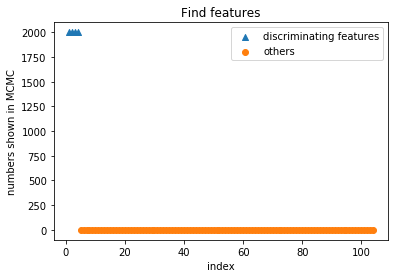

In [5]:
plt.scatter(range(1, 5), agent.total_gamma[0:4], marker='^', label="discriminating features")
plt.scatter(range(5, agent.total_gamma.shape[0]+1), agent.total_gamma[4:], marker='o', label="others")
plt.legend(loc='best')
plt.title("Find features")
plt.xlabel('index')
plt.ylabel('numbers shown in MCMC')
plt.savefig("./features.png")
plt.show()

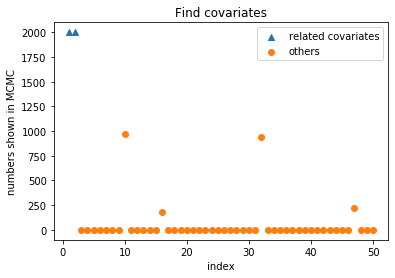

In [6]:
plt.scatter(range(1, 3), agent.total_delta[0, 0:2], marker='^', label="related covariates")
plt.scatter(range(3, agent.total_delta.shape[1]+1), agent.total_delta[0, 2:], marker='o', label="others")
plt.legend(loc='best')
plt.title("Find covariates")
plt.xlabel('index')
plt.ylabel('numbers shown in MCMC')
plt.savefig("./covariates1.png")
plt.show()

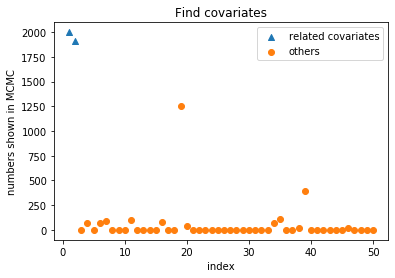

In [7]:
plt.scatter(range(1, 3), agent.total_delta[1, 0:2], marker='^', label="related covariates")
plt.scatter(range(3, agent.total_delta.shape[1]+1), agent.total_delta[1, 2:], marker='o', label="others")
plt.legend(loc='best')
plt.title("Find covariates")
plt.xlabel('index')
plt.ylabel('numbers shown in MCMC')
plt.savefig("./covariates2.png")
plt.show()